# Section 0 - Requirements and helper functions

In [5]:
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import Graph, URIRef, Literal, Namespace, RDF, RDFS, OWL, DC, DCTERMS
from csv import DictReader
from owlready2 import get_ontology, sync_reasoner_pellet

In [6]:
def camelCase(text: str):
    return "".join([letter for letter in text if letter.isalpha()]).title().replace(" ", "")

# Section 1 - Ontology population

In this section the knowledge graph is created by populating the empty ontology with instances and creating their relationships.

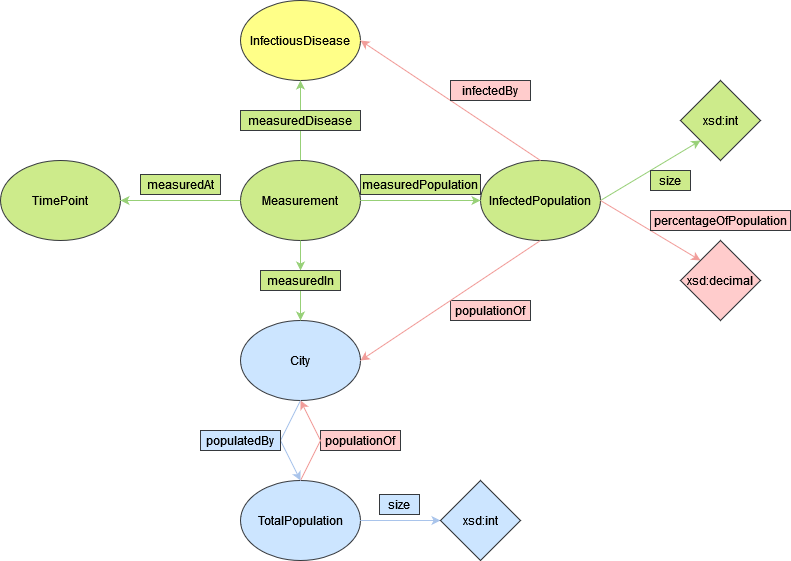
  
The yellow part of this graph is created in Subsection 1.2 - Infectious Diseases 
The blue parts of this graph are created in Subsection 1.3 - Cities and Population  
The green parts of this graph are created in Subsection 1.4 - Measurements  
The red parts of this graph are created in Subsection 1.6 - Pellet Reasoner 

## Subsection 1.1 Ontology extension

In this subsection the epi ontology is extended and linked to the human disease ontogy.

In [7]:
EPI = Namespace("http://github.com/jkuwalek/vrije-KnD-final-project/ontology/")
XSD = Namespace("http://www.w3.org/2001/XMLSchema#")
HDO = Namespace("http://purl.obolibrary.org/obo/")
GEN = Namespace("http://www.geneontology.org/formats/oboInOwl#")

graph = Graph()
with open("./data/epi-blank.ttl", "r") as f:
    graph.parse(f, format="turtle")

human_disease_ontology = Graph()
human_disease_ontology.parse(
    "https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/v2024-09-27/src/ontology/doid.owl",
    format="xml",
)

# Remove annotation properties that do not describe the joint ontology
human_disease_ontology.remove((HDO["doid.owl"], DC.title, Literal("Human Disease Ontology")))
human_disease_ontology.remove((HDO["doid.owl"], HDO["DOID_4"], None))
human_disease_ontology.remove((HDO["doid.owl"], DC.description, Literal(
    "The Disease Ontology has been developed as a standardized ontology for human disease with the purpose of providing the biomedical community with consistent, reusable and sustainable descriptions of human disease terms, phenotype characteristics and related medical vocabulary disease concepts."
)))
human_disease_ontology.remove((HDO["doid.owl"], DCTERMS.license, URIRef("https://creativecommons.org/publicdomain/zero/1.0/")))
human_disease_ontology.remove((HDO["doid.owl"], GEN.date, Literal("27:09:2024 15:14")))
human_disease_ontology.remove((HDO["doid.owl"], GEN["default-namespace"], Literal("disease_ontology")))
human_disease_ontology.remove((HDO["doid.owl"], GEN["saved-by"], Literal("lschriml")))
human_disease_ontology.remove((HDO["doid.owl"], RDFS.comment, Literal(
    "The Disease Ontology content is available via the Creative Commons Public Domain Dedication CC0 1.0 Universal license (https://creativecommons.org/publicdomain/zero/1.0/)."
)))
human_disease_ontology.remove((HDO["doid.owl"], OWL.imports, URIRef("http://purl.obolibrary.org/obo/doid/obo/ext.owl")))
human_disease_ontology.remove((HDO["doid.owl"], OWL.versionIRI, URIRef("http://purl.obolibrary.org/obo/doid/releases/2024-09-27/doid.owl")))
human_disease_ontology.remove((HDO["doid.owl"], OWL.versionInfo, Literal("2024-09-27")))
graph += human_disease_ontology

graph.bind("epi", EPI)
graph.bind("xsd", XSD)
graph.bind("hdo", HDO)
graph.bind("gen", GEN)

graph.add((EPI.Disease, OWL.equivalentClass, HDO.DOID_4)) # sameAs disease
graph.add((EPI.InfectiousDisease, OWL.equivalentClass, HDO.DOID_0050117)) # equivalentClass diseases by infectious agent

graph.serialize("generated_files/epi-extended.ttl", format="ttl")

SAXParseException: https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/v2024-09-27/src/ontology/doid.owl:250979:8: unclosed token

## Subsection 1.2 - Infectious Diseases (Yellow)

In this section the disease is specified, and is classified in the context of the human disease ontology. This classification is a manual process and has to be specified for every disease added. 

In [11]:
DISEASE_NAME = "Covid-19"
DISEASE_TAG = "C19"

graph.add((EPI[DISEASE_TAG], RDF.type, HDO.DOID_10533)) # type Viral pneumonia
graph.add((EPI[DISEASE_TAG], RDFS.label, Literal(DISEASE_NAME, lang="nl")))
graph.add((EPI[DISEASE_NAME], RDFS.label, Literal(DISEASE_NAME, lang="en")))

<Graph identifier=N19274c17d4664ce5b0e3b71ef335ba65 (<class 'rdflib.graph.Graph'>)>

## Subsection 1.3 - Cities and Population (Blue)

In this section the ontology is populated with dutch cities and their respective populations.

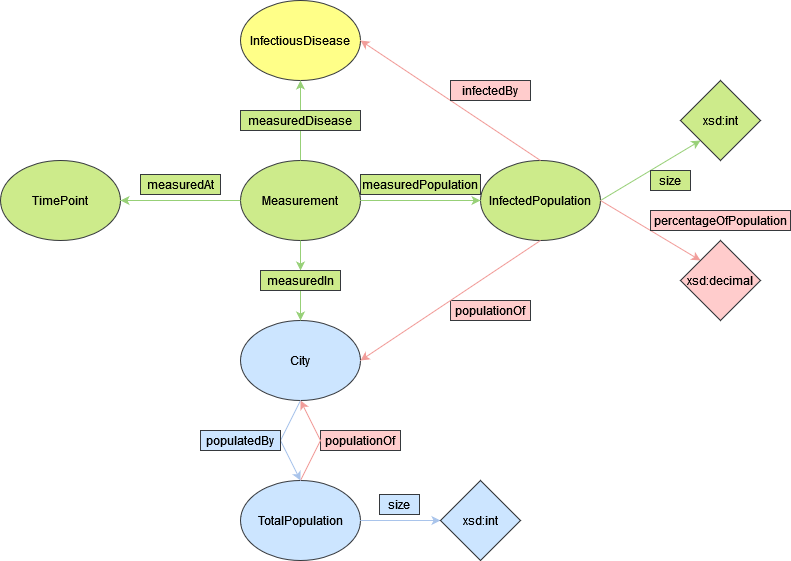

In [13]:
CITIES = {}
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
sparql.setReturnFormat(JSON)

sparql.setQuery(
    """
    SELECT DISTINCT ?city ?cityLabel_nl ?cityLabel_en ?population WHERE {
        ?city wdt:P31 wd:Q515 . # instance of city
        ?city wdt:P17 wd:Q55 . # country Netherlands
        ?city wdt:P1082 ?population .
        ?city rdfs:label ?cityLabel_en.
        ?city rdfs:label ?cityLabel_nl.

        FILTER(LANG(?cityLabel_en) = "en")
        FILTER(LANG(?cityLabel_nl) = "nl")
    }
    """
)

try:
    ret = sparql.queryAndConvert()
    if not isinstance(ret, dict):
        raise Exception("not isinstance(ret, dict)")

    for city in ret["results"]["bindings"]:
        CITIES[camelCase(city["cityLabel_nl"]["value"])] = [city["population"]["value"], city["cityLabel_nl"]["value"], city["cityLabel_en"]["value"]]

    for city_name, (population, label_nl, label_en) in CITIES.items():
        city_uri = EPI[city_name]
        population_uri = EPI[f"PopulationOf{ city_name }"]
        
        # Data Properties
        graph.add((city_uri, EPI.populatedBy, population_uri))
        graph.add((city_uri, RDF.type, EPI.City))
        graph.add(
            (
                population_uri,
                EPI.size,
                Literal(
                    population,
                    datatype=XSD["int"],
                ),
            )
        )

        # Labels
        graph.add((city_uri, RDFS.label, Literal(label_nl, lang="nl")))
        graph.add((city_uri, RDFS.label, Literal(label_en, lang="en")))
        graph.add((population_uri, RDFS.label, Literal(f"Population of {label_nl}", lang="nl")))
        graph.add((population_uri, RDFS.label, Literal(f"Population of {label_en}", lang="en")))
        
except Exception as e:
    print(e)
else:
    print("Success!")

Success!


## Subsection 1.4 - Measurements (Green)

In this subsection the measurements are extracted from a csv file and inserted into the ontology.

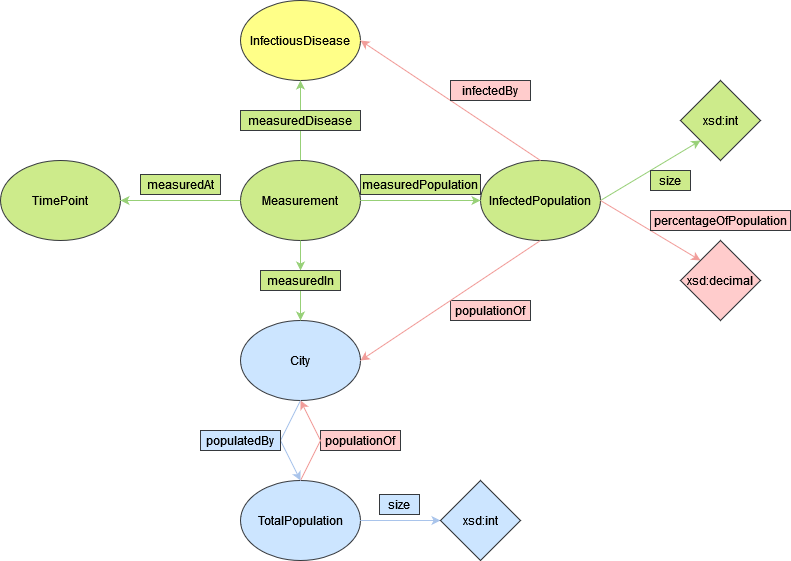

In [14]:
measurements = {}
with open("./data/COVID-19_aantallen_gemeente_per_dag.csv") as f:
    data = DictReader(f, delimiter=";")
    ommited_cities = set()

    counter = 0
    time_interval_start = None

    for dataPoint in data:
        city_name = camelCase(dataPoint["Municipality_name"])

        if city_name not in CITIES:
            ommited_cities.add(city_name)
            continue
        
        time_point = dataPoint["Date_of_publication"].replace("-", ".")
        cumulative_time_interval_data = {}

        # LIMIT TO ONLY 2 ENTRIES PER MONTH DUE TO ADVANCED SYSTEM REQUIREMENTS TO RUN THE REASONER
        # if not (time_point.endswith("-01") or time_point.endswith("-15")):
        #     continue
        if counter % 14 == 0:
            if time_interval_start is not None:
                for city in cumulative_time_interval_data:
                    measurements[city] = measurements.get(city_name, {})
                    measurements[city][time_point] = city.get(time_point, 0) + int(dataPoint["Total_reported"])
                temp_time_interval = {}

            time_interval_start = time_point 

        cumulative_time_interval_data[city_name] = cumulative_time_interval_data.get(city_name, 0) + 


                # Done this way to merge measurements of diffrent ROAZ_region (same municipality)

        counter += 1

for city_name, data in measurements.items():
    for time_point, total_infected in data.items():
        city_uri = EPI[city_name]
        measurement_uri = EPI["M" + DISEASE_TAG + city_name + time_point]
        infected_population_uri = EPI["IP" + DISEASE_TAG + city_name + time_point]
        time_point_uri = EPI[time_point]

        graph.add((measurement_uri, EPI.measuredIn, city_uri))
        graph.add((measurement_uri, EPI.measuredPopulation, infected_population_uri))
        graph.add(
            (infected_population_uri, EPI.size, Literal(total_infected, datatype=XSD["int"]))
        )
        graph.add((measurement_uri, EPI.measuredAt, time_point_uri))
        graph.add((measurement_uri, EPI.measuredDisease, EPI[DISEASE_TAG]))


print("Success!")
# print("The following cities have not been included in the knowledge graph:", "\n".join(ommited_cities))

Success!


## Subsection 1.5 - Exporting explicit triples

In this section the explicit triples created in the previous steps are exported in xml format.

In [15]:
try:
    graph.serialize(destination="generated_files/epi-explicit.owl", format="xml")
except Exception as e:
    print(e)
else:
    print("Success!")

Success!


## Subsection 1.6 - Pellet Reasoner (Red)

In this subsection new triples are inferred based on the explicit triples and rules generated in the previous steps.

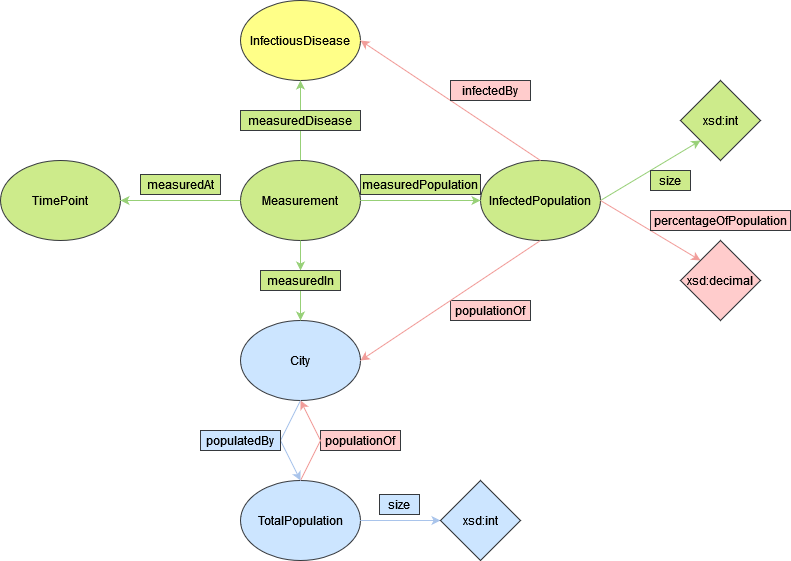

In [8]:
epi = get_ontology("generated_files/epi-explicit.owl").load()

with epi:
    sync_reasoner_pellet(infer_property_values=True, infer_data_property_values=True)

    # owlready2 is only capable of storing the data in xml format,
    # therefore we store it as xml and then convert to ttl too
    epi.save(file="generated_files/epi_with_inferrences.owl", format="rdfxml")

print("Success!")



* Owlready2 * Running Pellet...
    java -Xmx2000M -cp C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\antlr-3.2.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\antlr-runtime-3.2.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\aterm-java-1.6.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\commons-codec-1.6.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\httpclient-4.2.3.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\httpcore-4.2.2.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\jcl-over-slf4j-1.6.4.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\jena-arq-2.10.0.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\jena-core-2.10.0.jar;C:\Users\matus\AppData\Roaming\Python\Python312\sit

Success!


In [ ]:

full_knowledge_graph = Graph()
full_knowledge_graph.parse("generated_files/epi_with_inferrences.owl", format="xml")

# save as ttl as this is a submission requirement
full_knowledge_graph.serialize(destination="generated_files/epi_with_inferrences.ttl", format="ttl")


full_knowledge_graph.query("""

""")